In [21]:
%load_ext autoreload
%autoreload 1
%aimport nrrd_file

## Loading the cubes that are available on the vesuvius data server

In [35]:
from vesuvius import cubes

In [112]:
def parse_location_string(label):
    z, y, x = [int(substring) for substring in label.split('_')]
    return z, y, x


locations = []
for cube_location_string in list(cubes()[1][54][7.91].keys()):
    locations.append(parse_location_string(cube_location_string))

In [337]:
def save_cube(cube: Cube, mask=True):
    output_file_name = Path(cube.mask_url).name if mask else Path(cube.volume_url).name
    Nrrd.from_cube(cube, mask=mask).write(output_file_name)
    print(f"Wrote {output_file_name}")

In [ ]:
for z, y, x in locations:
    cube = Cube(scroll_id=1, energy=54, resolution=7.91, z=z, y=y, x=x, cache=False)
    save_cube(cube, mask=False)

## Matching labels from cube masks

In [493]:
import matplotlib.pyplot as plt
c1 = Nrrd.from_file("/Users/lachlan/Code/automatic-stitching-candidates/01744_02000_04304_mask.nrrd")
c2 = Nrrd.from_file("/Users/lachlan/Code/automatic-stitching-candidates/01744_02000_04560_mask.nrrd")

In [495]:
from typing import Tuple
from scipy import stats
Array3DIndex = Tuple[int | slice, int | slice, int | slice]

def get_matching_edge(giver: Nrrd, receiver: Nrrd, size_of_edge: int = 4) -> (Array3DIndex, Array3DIndex):
    giver_superior = giver.metadata['space origin'] > receiver.metadata['space origin']
    giver_inferior = giver.metadata['space origin'] < receiver.metadata['space origin']
    if not np.sum(giver_superior) + np.sum(giver_inferior) == 1:
        raise ValueError("Volumes must be adjacent.")

    if np.sum(giver_superior) == 1: # giver is superior along some axis
        giver_slice = tuple(slice(0, size_of_edge) if x else slice(None) for x in giver_superior)
        giver_edge_axis = np.where(np.array(giver_slice) != slice(None))[0][0]
        receiver_slice = tuple(slice(-1-size_of_edge,None) if x else slice(None) for x in giver_superior)
        receiver_edge_axis = np.where(np.array(receiver_slice) != slice(None))[0][0]
    elif np.sum(giver_inferior) == 1:
        giver_slice = tuple(slice(-1-size_of_edge, None) if x else slice(None) for x in giver_inferior)
        giver_edge_axis = np.where(np.array(giver_slice) != slice(None))[0][0]
        receiver_slice = tuple(slice(0, size_of_edge) if x else slice(None) for x in giver_inferior)
        receiver_edge_axis = np.where(np.array(receiver_slice) != slice(None))[0][0]


    giver_edge = stats.mode(giver.volume[giver_slice], axis=giver_edge_axis).mode
    receiver_edge = stats.mode(receiver.volume[receiver_slice], axis=receiver_edge_axis).mode
        
    return giver_edge, receiver_edge

giver_edge, receiver_edge = get_matching_edge(c1, c2, 1)

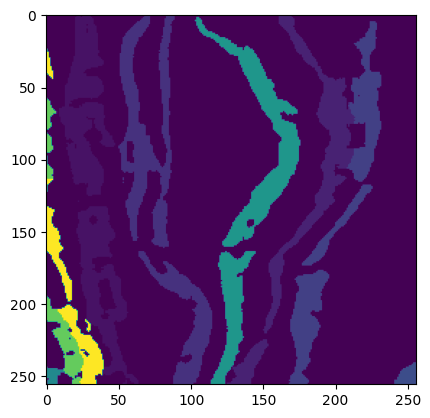

In [496]:
plt.imshow(giver_edge)

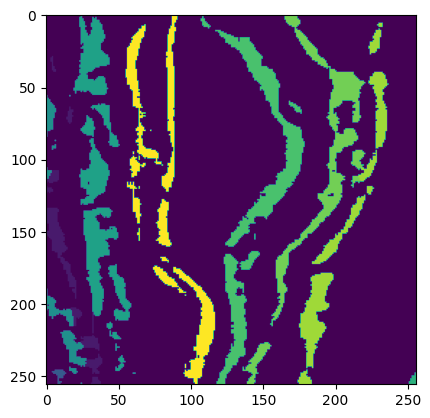

In [472]:
plt.imshow(receiver_edge)

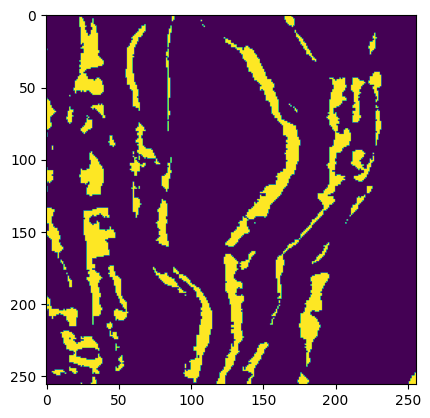

In [497]:
plt.imshow(np.logical_and(giver_edge != 0, receiver_edge != 0))

In [498]:
def find_papyrus_intersection(giver: Nrrd, receiver: Nrrd):
    giver_edge, receiver_edge = get_matching_edge(giver, receiver, 1)
    intersection = np.logical_and(giver_edge !=0, receiver_edge != 0)
    return intersection

intersection = find_papyrus_intersection(c1, c2)

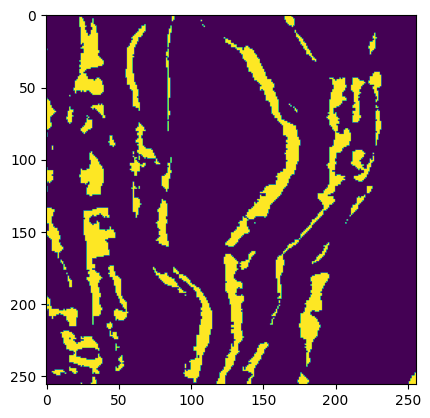

In [499]:
plt.imshow(intersection)

In [532]:
def create_label_mapping(giver, receiver, edge_thickness=4):
    MIN_REQUIRED_OVERLAP = 10
    counts = {}
    giver_edge, receiver_edge = get_matching_edge(giver, receiver, edge_thickness)
    intersection = np.logical_and(giver_edge != 0, receiver_edge != 0)
    for (a,b) in zip(receiver_edge[intersection], giver_edge[intersection]):
        if a in counts.keys():
            counts[a][b] += 1
        else:
            counts[a] = {i: 0 for i in range(32)}

    correspondences = {}
    for k, v in counts.items():
        highest = 0
        if max(v.values()) > MIN_REQUIRED_OVERLAP:
            for q, p in v.items():
                if p > v[highest]:
                    highest = q
        correspondences[k] = highest
    
    matched_keys = correspondences.keys()
    free_keys = [i for i in range(1,32) if i not in matched_keys]
    for i in range(1,32):
        if i not in matched_keys:
            correspondences[i] = free_keys.pop()
    return correspondences

In [533]:
correspondences = create_label_mapping(c1, c2)
print(correspondences)

{11: 2, 8: 1, 14: 3, 12: 4, 1: 21, 10: 11, 7: 16, 4: 10, 9: 0, 2: 31, 3: 30, 5: 29, 6: 28, 13: 27, 15: 26, 16: 25, 17: 24, 18: 23, 19: 22, 20: 21, 21: 20, 22: 19, 23: 18, 24: 17, 25: 16, 26: 15, 27: 13, 28: 6, 29: 5, 30: 3, 31: 2}


In [534]:
def match_labels(label_mapping: dict[int, int], volume):
    # Create lookup array with same dtype and known size
    lookup = np.zeros(33, dtype=np.uint8)  # 0-32 inclusive
    for k, v in label_mapping.items():
        lookup[k] = v
    
    # Map values using array indexing
    return lookup[volume]

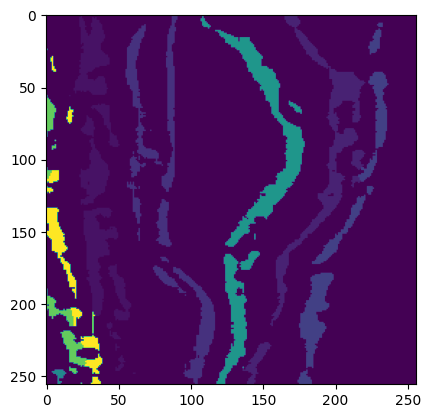

In [535]:
result = match_labels(correspondences, c2.volume)
plt.imshow(result[..., 0])

In [526]:
updated_c2 = Nrrd(result, c2.metadata)
updated_c2.write("../automatic-stitching-candidates/01744_02000_04560_mask_updated.nrrd")

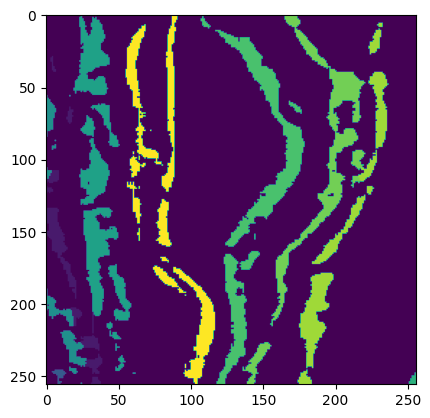

In [527]:
plt.imshow(c2.volume[..., 0])

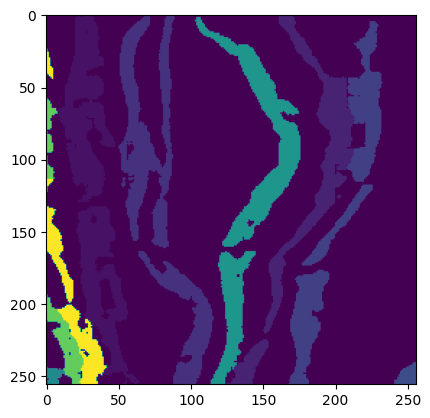

In [528]:
plt.imshow(c1.volume[..., -1])

## Tying it all together

In [568]:
from typing import Tuple
from scipy import stats
Array3DIndex = Tuple[int | slice, int | slice, int | slice]

def get_matching_edge(giver: Nrrd, receiver: Nrrd, edge_offset: int = 2) -> (Array3DIndex, Array3DIndex):
    giver_superior = giver.metadata['space origin'] > receiver.metadata['space origin']
    giver_inferior = giver.metadata['space origin'] < receiver.metadata['space origin']
    if not np.sum(giver_superior) + np.sum(giver_inferior) == 1:
        raise ValueError("Volumes must be adjacent.")

    if np.sum(giver_superior) == 1: # giver is superior along some axis
        giver_slice = tuple(edge_offset if x else slice(None) for x in giver_superior)
        receiver_slice = tuple(-edge_offset if x else slice(None) for x in giver_superior)
    elif np.sum(giver_inferior) == 1:
        giver_slice = tuple(-edge_offset if x else slice(None) for x in giver_inferior)
        receiver_slice = tuple(edge_offset if x else slice(None) for x in giver_inferior)

    return giver.volume[giver_slice], receiver.volume[receiver_slice]

In [569]:
def create_label_mapping(giver, receiver, offset=2):
    MIN_REQUIRED_OVERLAP = 10
    counts = {}
    giver_edge, receiver_edge = get_matching_edge(giver, receiver, offset)
    intersection = np.logical_and(giver_edge != 0, receiver_edge != 0)
    for (a,b) in zip(receiver_edge[intersection], giver_edge[intersection]):
        if a in counts.keys():
            counts[a][b] += 1
        else:
            counts[a] = {i: 0 for i in range(32)}

    correspondences = {}
    for k, v in counts.items():
        highest = 0
        if max(v.values()) > MIN_REQUIRED_OVERLAP:
            for q, p in v.items():
                if p > v[highest]:
                    highest = q
        correspondences[k] = highest
    
    matched_keys = correspondences.keys()
    free_keys = [i for i in range(1,32) if i not in matched_keys]
    for i in range(1,32):
        if i not in matched_keys:
            correspondences[i] = free_keys.pop()
    return correspondences

In [577]:
# load two adjacent masks

b1 = Nrrd.from_file("/Users/lachlan/Code/cubes/10448_02512_02512_mask.nrrd")
b2 = Nrrd.from_file("/Users/lachlan/Code/cubes/10448_02512_02256_mask.nrrd")

# giver_edge, receiver_edge = get_matching_edge(b1, b2, 8)
correspondences = create_label_mapping(b1, b2)
result = match_labels(correspondences, b2.volume)

b2_updated = Nrrd(result, b2.metadata)
# b2_updated.write("/Users/lachlan/Code/automatic-stitching-candidates/b2_mask.nrrd")
# b1.write("/Users/lachlan/Code/automatic-stitching-candidates/b1_mask.nrrd")

In [584]:
new_giver_edge, new_receiver_edge = get_matching_edge(b2, b1)


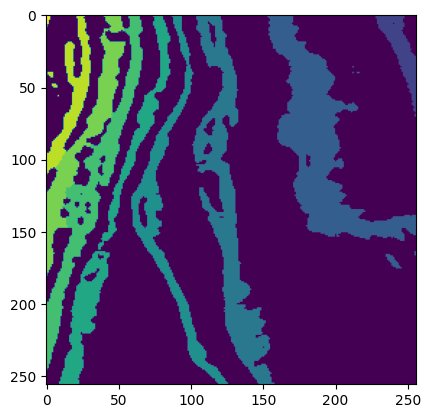

In [585]:
plt.imshow(new_giver_edge)

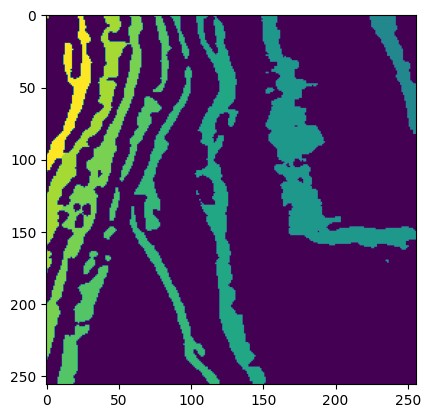

In [586]:
plt.imshow(new_receiver_edge)

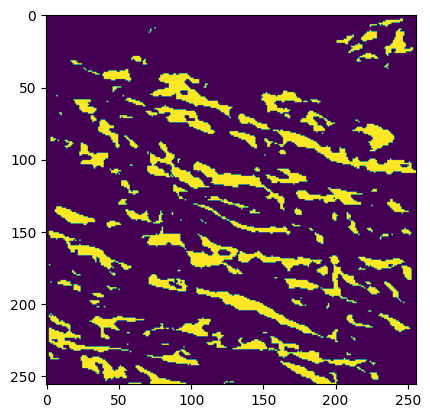

In [575]:
plt.imshow(np.logical_and(new_giver_edge == new_receiver_edge, new_giver_edge != 0))